In [1]:
import torch 
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from dataset import LuciferaseDataset
from models import fc_encoder, fc_decoder, MSA_VAE
from utils import seq_to_ohe, ohe_to_seq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from Bio import SeqIO
import matplotlib.pyplot as plt
import requests 
from sklearn.metrics import pairwise_distances

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# sample 3000
# pca encoded

In [3]:
ENCODER_KWARGS = {'latent_dim' : 10,
        'seq_len' : 360,
        'encoder_hidden' : [256, 256],
        'encoder_dropout' : [0, 0],
        }

DECODER_KWARGS = {'latent_dim' : 10,
        'seq_len' : 360,
        'decoder_hidden' : [256, 256],
        'decoder_dropout' : [0, 0]}

BATCH_SIZE=32
VALID_FASTA = './data/luxafilt_llmsa_val.fa'

luxA = 'MKFGNFLLTYQPPQFSQTEVMKRLVKLGRISEECGFDTVWLLEHHFTEFGLLGNPYVAAAYLLGATKKLNVGTAAIVLPTAHPVRQLEDVNLLDQMSKGRFRFGICRGLYNKDFRVFGTDMNNSRALAECWYGLIKNGMTEGYMEADNEHIKFHKVKVNPAAYSRGGAPVYVVAESASTTEWAAQFGLPMILSWIINTNEKKAQLELYNEVAQEYGHDIHNIDHCLSYITSVDHDSIKAKEICRKFLGHWYDSYVNATTIFDDSDQTRGYDFNKGQWRDFVLKGHKDTNRRIDYSYEINPVGTPQECIDIIQKDIDATGISNICCGFEANGTVDEIIASMKLFQSDVMPFLKEKQRSLLY'

In [4]:
print(len(luxA))

360


In [5]:
def sample(model_checkpoint, n_samples, stdev=0.01):
    
    # load model
    encoder = fc_encoder(**ENCODER_KWARGS)
    decoder = fc_decoder(**DECODER_KWARGS)
    model = MSA_VAE(encoder, decoder)
    checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # encode template luxA
    luxa_ohe = torch.tensor(seq_to_ohe(luxA)).reshape(1, 21, 360).float()
    luxa_ohe = luxa_ohe.repeat(n_samples, 1, 1)
    
    mu, logvar = model.encoder(luxa_ohe)
    z = model.reparameterize(mu, logvar)
    
    # add noise
    if stdev > 0.0:
        noise = torch.normal(0, stdev, z.shape)
        z += noise
    
    # decode
    # permute does not work?
    decoded = model.decoder(z).detach().reshape(-1, 360, 21).numpy()
    
    # ohe to sequence
    seqs = []
    for i in range(decoded.shape[0]):
        seq = ohe_to_seq(decoded[i, ...])
        seqs.append(seq)
        
#     x_rec, mu, logvar = model(luxa_ohe)
#     out_seq = ohe_to_seq(x_rec.detach().cpu().numpy().reshape(360, 21))
#     print(out_seq)
    
    # fasta output
    with open('sampled_variants.fasta', 'w') as f:
        for i, seq in enumerate(seqs, 1):
            f.write(f'>generated_{i}\n')
            f.write(seq)
            f.write('\n')

In [9]:
sample('checkpoints/luciferase_14.pt', 1000, 0.5)

In [10]:
!head sampled_variants.fasta

>generated_1
MKANNVDN-DVQCKEH-EEVMKAALNQGKLSEPCGFKALWVLEHHFTDFGLVPNPYQMVAYVAGLTEKLNVGTAAAVVTTADPVRQAEDVALLDLMSKGRYTFGISRGVYKKDFDAAGRD-DNSQAIFNDWYDLLKLGFRGEYFSYDNQIFNFP-VQVLPRPVSPDGPKVY-VSESAKTTEWAVNQGLPFILSNSGNTERMKEILDLTNNVTQEHGKSVTDPTHCLSYFTAINADSNEPKRIERNRATHWIDEINV-YKNFDDY---KISGTN--VLREF-----K-TD-RLLYSAENNPIGTIEECFAIIEAFRRIASIDEI-CGGFGGLS-QEIIASVHLFAKKVM-FVK-KQRSLYP
>generated_2
MKVNIGGNNDEQCKMHFEEVLAAALEMG-Y--GLNFDAVAVLENHFTPNGIVGAPITMAAYLAGRTERVGVMSLNAVVTTHDPVRVAEDVALLDQMSEGRFTFGFSICENKDEFDAFGR--DYQQQLFNECYELLLNAFTEGYFEPDNDFFSFP-ISVNPHPVTPDGPKVYVGATS-HATEWAAKFGLPLILKNSINNAVRKELLDLVHEVRAHHGKIQIDHTL-LSILTNYNADSDKAKEEERSVRNHWVDEVTT-Y--F-DY----MYP-N-G-AR-------ENFEKRALESIEINAIGTYEECYAAIQEVLK-CGITEI--LS-ATMT--EVVSSVKLFAKKVMSF--Q-Q-SALP
>generated_3
ESTWNCVFAPEQCVETHAEVMKRLVELGIASEAGGFDAVWVLEHHFTDF-IVGNPYVFVAYLAGRTTRLHLGTGIIVLTTAHPVRVAEDVALLDVMSGGRFNFGVGRGAYQIDFDVFG-D-DS-RQLMEESVELLRKGFRTDYIAHDGDFIKFP--TVYPKPVS-AGPPVWMAA-SADTTEWAAARGLPLILS-IINTDAVKELLNLVNEV-QH--NPI-QITV-L-LHTVVNEDAAKA

In [13]:
def get_latent(model_checkpoint):
    
    # load model
    encoder = fc_encoder(**ENCODER_KWARGS)
    decoder = fc_decoder(**DECODER_KWARGS)
    model = MSA_VAE(encoder, decoder)
    checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # forward val
    valid_dataset = LuciferaseDataset(VALID_FASTA)
    valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=BATCH_SIZE)
    
    # encode and save
    arr = None
    for batch_idx, x in enumerate(valid_loader):
        
        mu, logvar = model.encoder(x.float())
        z = model.reparameterize(mu, logvar).detach().numpy()
        
        if arr is None:
            arr = z
        else:
            arr = np.concatenate((arr, z), axis=0)
            
    return arr

In [14]:
arr = plot_latent('checkpoints/luciferase_14.pt', 'afdas', 'sfas')

In [15]:
arr.shape

(13923, 10)

In [20]:
def get_labels(fasta):

    records = SeqIO.parse(fasta, 'fasta')
    
    labels = []
    for record in records:
        labels.append(record.id)
        
    return labels
    

In [22]:
get_labels('./data/luxafilt_llmsa_val.fa')[:10]

['A1A9R7',
 'A1JMY1',
 'A3Q7Z7',
 'A4VQH4',
 'A4W925',
 'A6T7A2',
 'A7ME52',
 'A7ZKB7',
 'A7ZYW7',
 'A8GCT6']

In [69]:
def label_latent(latent, valid_fasta, labels_df, top_groups):
    
    # norm and pca
    sc = StandardScaler()
    latent_sc = sc.fit_transform(latent)
    
    #pca = PCA(n_components=2)
    #latent_pca = pca.fit_transform(latent_sc)
    
    tsne = TSNE()
    latent_tsne = tsne.fit_transform(latent_sc)
    
    # label the samples
    labels = get_labels(valid_fasta)
    
    df = pd.DataFrame(latent_tsne, columns=['X0', 'X1'])
    df['labels'] = labels
    
    # only keep first ipro
    ipro_labels = pd.read_csv(labels_df)
    ipro_filt = ipro_labels.query("ipro in @top_groups")
    ipro_filt['ipro'] = ipro_filt['ipro'].astype('category')
    ipro_filt['ipro'] = ipro_filt['ipro'].cat.reorder_categories(top_groups)
    ipro_filt.sort_values(by=['ipro'], inplace=True)
    ipro_filt.drop_duplicates('accession', inplace=True)
    
    # merge labels with ipro accessions
    merged = df.merge(ipro_filt, left_on='labels', right_on='accession', how='inner')
    
    # save selected groups
    merged = merged.query("ipro in @top_groups")
    
    return merged[['accession', 'X0', 'X1', 'ipro']]
    

In [70]:
top_groups = save = ['IPR016215', 'IPR019949', 'IPR019952', 'IPR019945', 'IPR022290', 
                     'IPR019911', 'IPR019951', 'IPR023934', 'IPR024014']
latent = label_latent(arr, './data/luxafilt_llmsa_val.fa', './data/valid_ipro_labels.csv', top_groups)

/home/eking/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/eking/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/eking/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [71]:
print(latent.shape)
latent.head()

(4975, 4)


,accession,X0,X1,ipro
0,A9FK50,-44.441586,-53.393028,IPR019911
1,B3QIN8,-45.452377,-48.266747,IPR019911
2,O34846,-6.281815,-29.793333,IPR019949
3,O53565,-19.699421,78.253830,IPR019951
4,P54995,12.883926,2.917811,IPR016215


In [157]:
def plot_latent(latent_df):
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    df_grp = latent_df.groupby('ipro')
    for group, data in df_grp:
        ax.scatter(data['X0'], data['X1'], label=group, alpha=0.1, s=8)
        
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for lh in leg.legendHandles:
        lh.set_alpha(1)
        lh.set_sizes([30])
        
    ax.set_xlabel('TSNE 1', size=14)
    ax.set_ylabel('TSNE 2', size=14)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title('MSA-VAE')

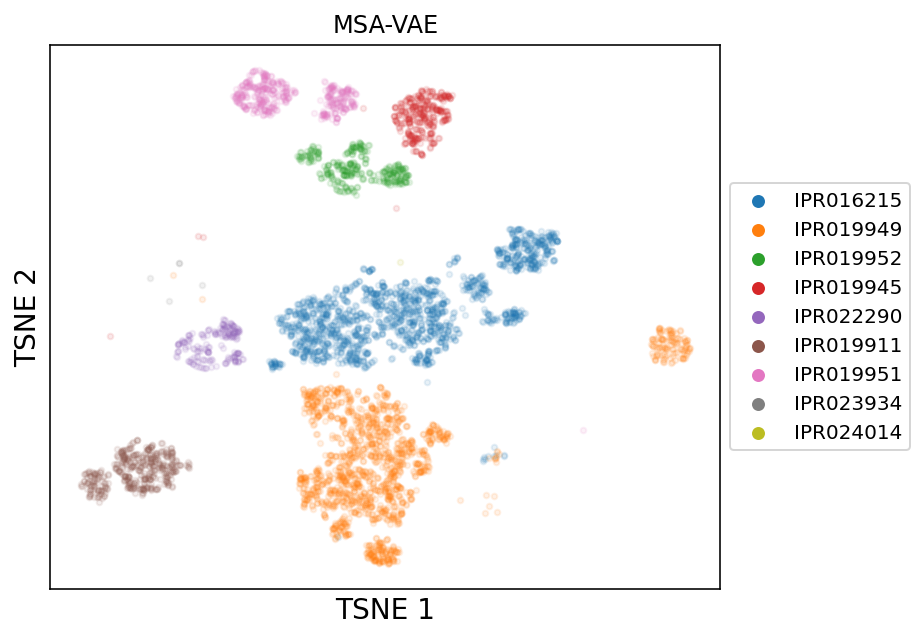

In [158]:
plot_latent(latent)
plt.savefig('latent.png', bbox_inches='tight', dpi=300)

In [119]:
def get_ca_coords(pdb='1LUC', chain='A'):
    
    url = f'https://files.rcsb.org/download/{pdb}.pdb'
    r = requests.get(url)
    r.raise_for_status()
    
    lines = r.text.splitlines()
    
    out = []
    
    for line in lines:
        if line.startswith('ATOM ') and line.split()[4] == 'A' and line.split()[2] == 'CA':
            resi = line.split()[5]
            resn = line.split()[3]
            x = line.split()[6]
            y = line.split()[7]
            z = line.split()[8]
            
            out.append([resi, resn, x, y, z])
            
    df = pd.DataFrame(out, columns=['res_num', 'res_name', 'x', 'y', 'z'])
    
    return df

In [120]:
ca_coords = get_ca_coords()

In [121]:
ca_coords

,res_num,res_name,x,y,z
0,1,MET,65.196,8.000,5.806
1,2,LYS,61.878,7.545,7.562
2,3,PHE,60.705,9.250,10.658
3,4,GLY,58.224,8.129,13.322
4,5,ASN,56.677,10.081,16.245
...,...,...,...,...,...
321,351,LEU,71.049,12.179,8.996
322,352,LYS,72.481,9.862,6.366
323,353,GLU,71.808,6.190,5.541
324,354,LYS,74.679,3.811,6.448


In [122]:
def luciferase_contact_map(seq_gap=4, contact_cutoff=6):
    
    # download pdb and save ca coordinates
    ca_coords = get_ca_coords()
    
    # pairwise distances
    dist_arr = pairwise_distances(ca_coords[['x', 'y', 'z']].values)
    
    # remove neighboring residues 
    return dist_arr
    
    

In [123]:
dist_arr = luciferase_contact_map()

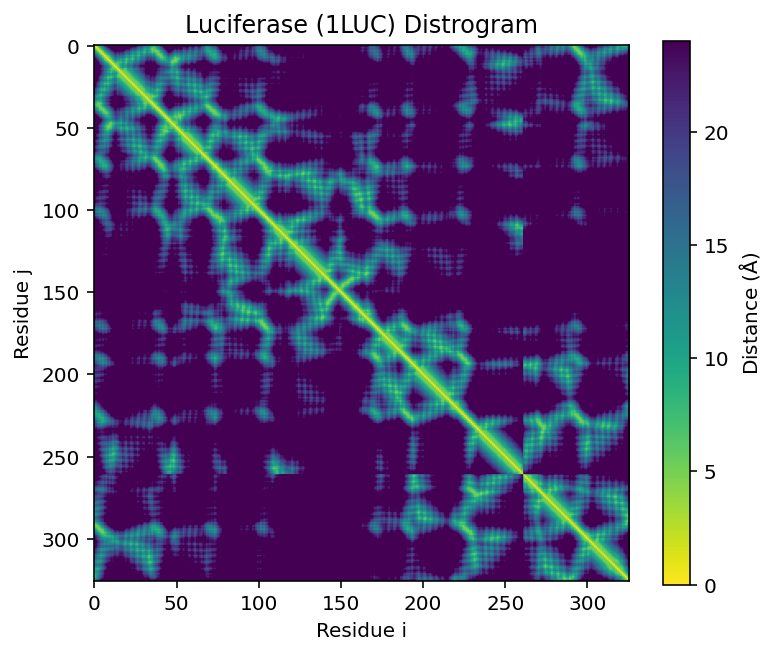

In [126]:
fig = plt.figure(figsize=(6, 5))

p = plt.imshow(dist_arr, cmap='viridis_r', vmax=24, vmin=0)
plt.colorbar(p, label='Distance ($\mathrm{\AA}$)')
plt.xlabel('Residue i')
plt.ylabel('Residue j')
plt.title('Luciferase (1LUC) Distrogram')
plt.savefig('iluc_distro.png', bbox_inches='tight', dpi=300)

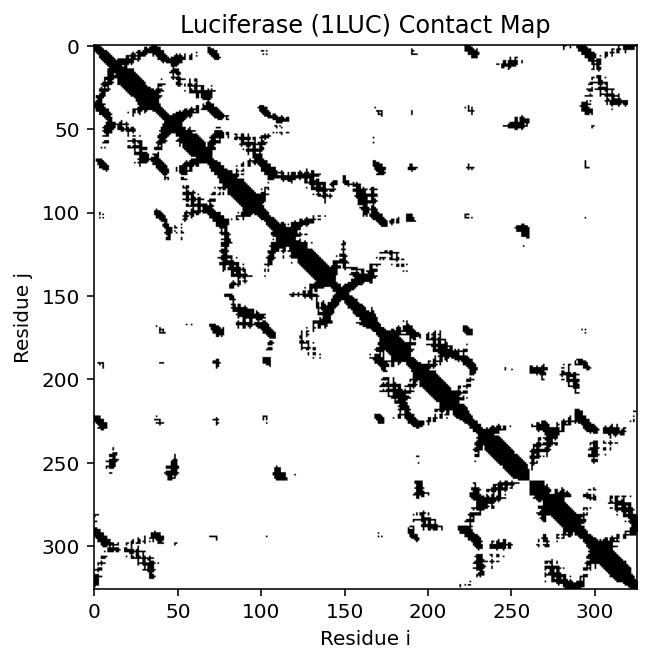

In [132]:
fig = plt.figure(figsize=(6, 5))

p = plt.imshow(dist_arr < 13, cmap='binary', vmax=1, vmin=0)
#plt.colorbar(p, label='Contact')
plt.xlabel('Residue i')
plt.ylabel('Residue j')
plt.title('Luciferase (1LUC) Contact Map')
plt.savefig('iluc_distro_binary.png', bbox_inches='tight', dpi=300)

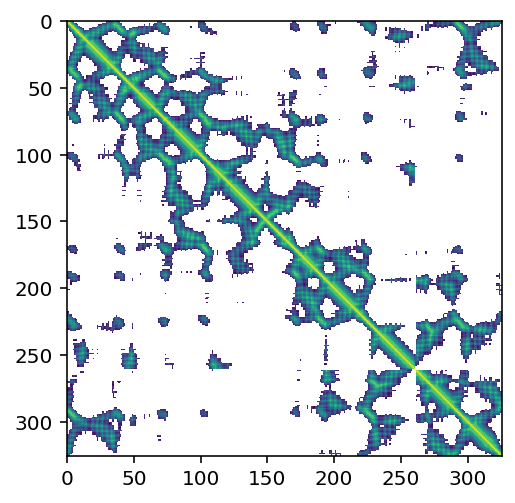

In [243]:
plt.imshow(np.where(dist_arr < 20, dist_arr, np.nan), vmax=20, vmin=0, cmap='viridis_r')

In [161]:
dists = []
for a in arr:
    if (a[0] < len(dist_arr)) and (a[1] < len(dist_arr)):
        dists.append(dist_arr[a[0], a[1]])
    else:
        dists.append(np.nan)
        

In [180]:
def plot_ccpred(ccpred, prot_len=360):
    
    fig = plt.figure(figsize=(6, 5))
    
    with open(ccpred, 'r') as f:
        lines = f.read().splitlines()
        
    arr = np.zeros((prot_len, prot_len), dtype=int)
    for line in lines:
        if not line.startswith('#'):
            i = int(line.split()[0])
            j = int(line.split()[1])
            
            arr[i, j] = 1
            arr[j, i] = 1
            
    #arr = np.where(arr == 1, arr, np.nan)
    #plt.imshow(arr, cmap='binary', vmax=1, vmin=0) 
    
    arr = np.transpose((arr == 1).nonzero())
    p = plt.scatter(arr[:, 0], arr[:, 1], s=5, c=dists, cmap='inferno', vmax=22)
    plt.gca().invert_yaxis()
    
    #plt.colorbar(p)
    plt.xlabel('Residue i')
    plt.ylabel('Residue j')
    plt.colorbar(p, label='Distance ($\mathrm{\AA}$)')
    plt.title('MSA-VAE CCMPred Couplings')
            
    return arr
            
            

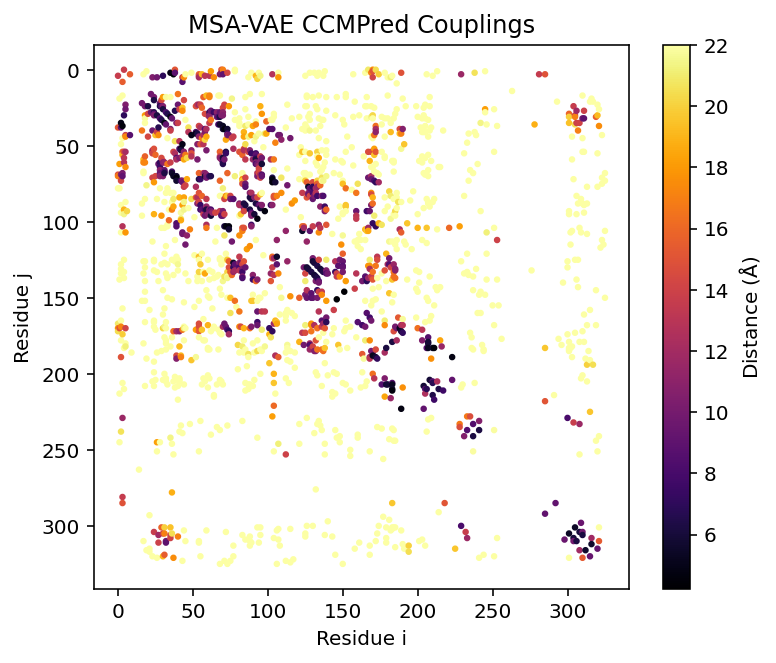

In [181]:
arr = plot_ccpred('./data/ccpred_top.txt')
plt.savefig('ccmpred.png', bbox_inches='tight', dpi=300)

In [93]:
np.transpose((arr == 1).nonzero())

array([[  7,  28],
       [  7, 110],
       [  7, 134],
       ...,
       [357, 159],
       [357, 161],
       [357, 162]])